In [1]:
from __future__ import print_function
import numpy as np
import torch
from torch.autograd import Variable
import pyro
from pyro.optim import Adam
from pyro.infer import SVI
import pyro.distributions as dist

In [53]:
pyro.clear_param_store()

In [54]:
data = []
for _ in range(6):
    data.append(Variable(torch.ones(1)))
for _ in range(4):
    data.append(Variable(torch.zeros(1)))

In [55]:
def model(data):
    alpha0 = Variable(torch.Tensor([10.0]))
    beta0  = Variable(torch.Tensor([10.0]))
    f = pyro.sample("latent_fairness", dist.beta, alpha0, beta0)
    for i in range(len(data)):
        pyro.observe("obs_{}".format(i), dist.bernoulli, data[i], f)

In [56]:
def guide(data):
    #why log 15?
    #How does defining alpha/beta in log space keep them non-negative? What if they'r [0, 1)
    log_alpha0 = Variable(torch.Tensor([np.log(15.0)]), requires_grad = True)
    log_beta0  = Variable(torch.Tensor([np.log(15.0)]), requires_grad = True)
    log_alpha  = pyro.param("log_alpha", log_alpha0)
    log_beta   = pyro.param("log_beta", log_beta0)
    alpha      = torch.exp(log_alpha)
    beta       = torch.exp(log_beta)
    pyro.sample("latent_fairness", dist.beta, alpha, beta)

In [57]:
adam_params = { 'lr':  0.0005, 'betas': (0.90, 0.999)}
optimizer   = Adam(adam_params)
svi         = SVI(model, guide, optimizer, loss="ELBO", num_particles=7)
n_steps = 4000
for step in range(n_steps):
    svi.step(data)
    if step % 100 == 0:
        print(".", end='')

........................................

In [58]:
alpha = torch.exp(pyro.param("log_alpha")).data.numpy()[0]
beta  = torch.exp(pyro.param("log_beta")).data.numpy()[0]
print(beta)
inferred_mean = alpha / (alpha + beta)

factor = beta / (alpha  * (1 + alpha + beta))
inferred_std_dev = inferred_mean * np.sqrt(factor)

13.925237


In [59]:
print("Inferred Mean: {}, Inferred Std Dev {}".format(inferred_mean, inferred_std_dev))

Inferred Mean: 0.537561297416687, Inferred Std Dev 0.08938668212109199


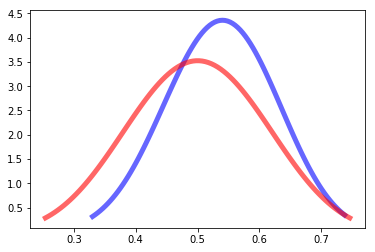

In [60]:
from scipy.stats import beta as beta_dist
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(1, 1)
a, b = float(alpha), float(beta)
x = np.linspace(beta_dist.ppf(0.01, a, b), beta_dist.ppf(0.99, a, b), 100)
ax.plot(x, beta_dist.pdf(x, a, b),'b-', lw=5, alpha=0.6, label='posterior')
a2, b2 = 10.0, 10.0
x = np.linspace(beta_dist.ppf(0.01, a2, b2), beta_dist.ppf(0.99, a2, b2), 100)
ax.plot(x, beta_dist.pdf(x, a2, b2),'r-', lw=5, alpha=0.6, label='prior')